# Imports

In [1]:
import openmeteo_requests

import requests

from shared_utilities import *

import requests_cache

from retry_requests import retry

import matplotlib.pyplot as plt

from openmeteo_sdk.Variable import Variable
from openmeteo_sdk.Aggregation import Aggregation

KeyboardInterrupt: 

In [2]:
import pandas as pd

# Wind Farms

In [3]:
wind_farms = [
    {"name": "Amakhala Emoyeni", "location": [-32.6030, 25.9280]},
    {"name": "Aurora Wind Power", "location": [-32.9141, 17.9911]},
    {"name": "Chaba Wind Farm", "location": [-32.8250, 27.8250]},
    {"name": "Cookhouse Wind Farm", "location": [-32.7494, 25.6931]},
    {"name": "Copperton Windfarm", "location": [-29.9569, 24.7083]},
    {"name": "Dassieklip Wind Energy Facility", "location": [-34.1872, 19.4328]},
    {"name": "Dorper Wind Farm", "location": [-31.4072, 26.3624]},
    {"name": "Excelsior Wind Energy Facility", "location": [-34.0226, 20.4417]},
    {"name": "Garob Wind Farm", "location": [-29.9556, 24.7081]},
    {"name": "Golden Valley Wind", "location": [-32.7955, 25.7254]},
    {"name": "Gouda Wind Project", "location": [-33.3194, 19.1000]},
    {"name": "Grassridge Wind Farm", "location": [-33.7975, 25.6251]},
    {"name": "Jeffreys Bay Wind Farm", "location": [-34.0500, 24.9200]},
    {"name": "Kangnas Wind Farm", "location": [-29.6811, 17.8778]},
    {"name": "Khobab Wind Farm", "location": [-31.3500, 19.7500]},
    {"name": "Kouga Wind Farm", "location": [-34.0472, 24.9225]},
    {"name": "Loeriesfontein 2 Wind Farm", "location": [-30.8865, 19.8085]},
    {"name": "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility", "location": [-30.6815, 24.0125]},
    {"name": "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility", "location": [-30.6485, 23.9442]},
    {"name": "Metrowind Van Stadens Wind Farm", "location": [-33.9126, 25.2482]},
    {"name": "Nobelsfontein Phase 1", "location": [-31.3831, 23.1906]},
    {"name": "Nojoli Wind Farm", "location": [-32.8081, 25.6673]},
    {"name": "Noupoort Wind Farm", "location": [-31.6381, 24.8819]},
    {"name": "Nxuba Wind Farm", "location": [-32.7071, 25.7333]},
    {"name": "Oyster Bay Wind Farm", "location": [-34.0261, 24.9467]},
    {"name": "Perdekraal East Wind Farm", "location": [-33.3400, 19.2500]},
    {"name": "Red Cap – Gibson Bay", "location": [-34.0333, 24.9167]},
    {"name": "Roggeveld Wind Farm", "location": [-32.3928, 20.8311]},
    {"name": "Sere Wind Farm", "location": [-31.7500, 18.0833]},
    {"name": "The Karusa Wind Farm", "location": [-32.3906, 20.8242]},
    {"name": "Tsitsikamma Community Wind Farm", "location": [-34.1862, 24.5256]},
    {"name": "Umoya Energy Wind Farm", "location": [-33.0011, 18.3486]},
    {"name": "Waainek Wind Farm", "location": [-33.3042, 26.5247]},
    {"name": "Wesley-Ciskei", "location": [-34.0167, 26.5333]}
]

wind_farms_df = pd.DataFrame(wind_farms)
wind_farms_df[['latitude', 'longitude']] = pd.DataFrame(wind_farms_df['location'].tolist())
wind_farms_df.drop('location', axis=1, inplace=True)
wind_farms_df = wind_farms_df.set_index('name')

wind_farms_df.to_csv('wind_farms.csv')

In [3]:
farm = 'Sere Wind Farm'
latitude = wind_farms_df.loc[farm]['latitude']
longitude = wind_farms_df.loc[farm]['longitude']

print(f'Retrieving data for {farm} at {latitude}, {longitude}')

Retrieving data for Sere Wind Farm at -31.75, 18.0833


# Extract from OpenWeatherMap

Not needed


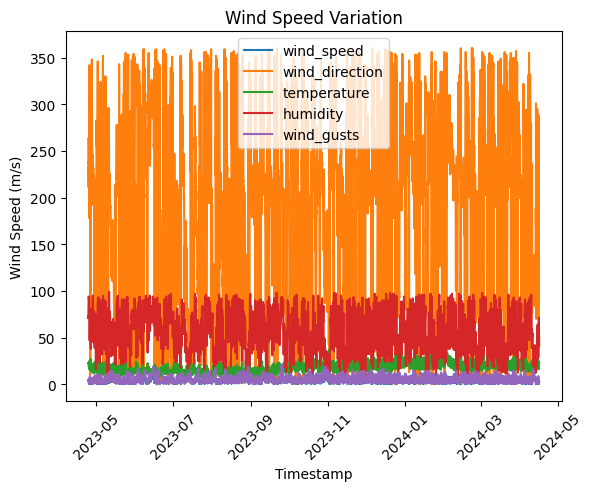

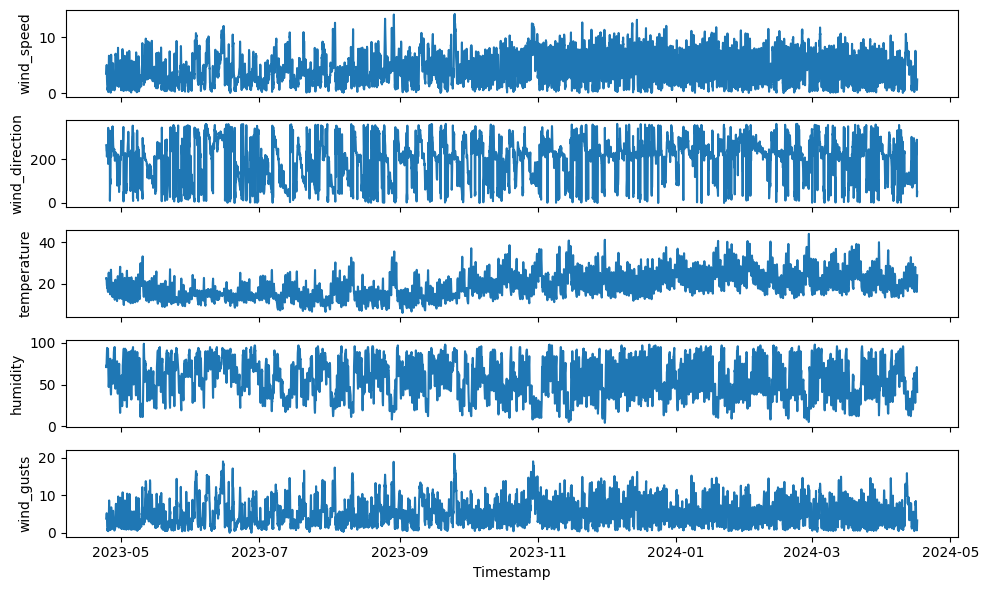

In [4]:
needed = False

api_key = '7552f271b24168a6c4ef09611a862ff8'
base_url = f'https://api.openweathermap.org/data/2.5/weather'

if needed:
    weather_data = []

    weeks = 52

    start_timestamp_iso, end_timestamp_iso, today = get_dates(weeks_=weeks)
    end_timestamp_unix = int(datetime.fromisoformat(end_timestamp_iso).timestamp())
    start_timestamp_unix = int(datetime.fromisoformat(start_timestamp_iso).timestamp())

    for i in range(weeks):
        print(f'Progress: {i}/{weeks}', end='\r')
        start_timestamp_unix += 604800
        end_timestamp_unix = start_timestamp_unix + 604800
        

        url = f'https://history.openweathermap.org/data/2.5/history/city?lat={latitude}&lon={longitude}&start={start_timestamp_unix}&end={end_timestamp_unix}&appid={api_key}&units=metric'

        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()

            
            for item in data['list']:
                timestamp = item['dt']
                datetime_obj = datetime.utcfromtimestamp(timestamp)
                timestamp_iso = datetime_obj.isoformat()
                temperature = item['main']['temp']
                humidity = item['main']['humidity']
                wind_speed = item['wind']['speed']
                wind_direction = item['wind']['deg']
                try:
                    wind_gusts = item['wind']['gust']
                except:
                    wind_gusts = 0
                weather_data.append({'timestamp': timestamp_iso, 'wind_speed': wind_speed,
                                     'wind_direction': wind_direction,
                                     'temperature': temperature, 'humidity': humidity, 
                                     'wind_gusts' : wind_gusts})
        
            weather_df = pd.DataFrame(weather_data)
            weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
            weather_df.set_index('timestamp', inplace=True)
        else:
            # Print an error message if the request was unsuccessful
            print(f"Error: {response.status_code}")
            print(url)

    weather_df.to_csv(f'data\{farm}_hourly_OWM.csv')

    print('Gathered data')
else:
    weather_df = pd.read_csv(f'data\{farm}_hourly_OWM.csv', index_col='timestamp', parse_dates=True)
    print('Not needed')

plt.plot(weather_df)
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Variation')
plt.legend(weather_df.columns)
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots(nrows=len(weather_df.columns), ncols=1, figsize=(10, 6), sharex=True)

# Plot each feature
for i, column in enumerate(weather_df.columns):
    axes[i].plot(weather_df.index, weather_df[column], label=column)
    axes[i].set_ylabel(column)

# Set common x-axis label
axes[-1].set_xlabel('Timestamp')

plt.tight_layout()
plt.show()

# Extract from Open Meteo

Coordinates -31.73989486694336°N 18.043216705322266°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


<Axes: xlabel='timestamp'>

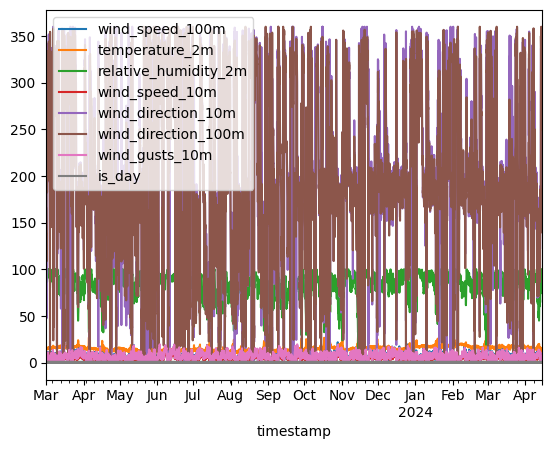

In [5]:
save = False

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2023-03-01",
	"end_date": "2024-04-16",
	"hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "is_day"],
	"wind_speed_unit": "ms"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_is_day = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"timestamp": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["is_day"] = hourly_is_day

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.dropna(inplace = True)

hourly_dataframe.set_index("timestamp", inplace = True)
if save:
	hourly_dataframe.to_csv(f"data\{farm}_hourly_OM.csv")

hourly_dataframe.plot()


# Compare

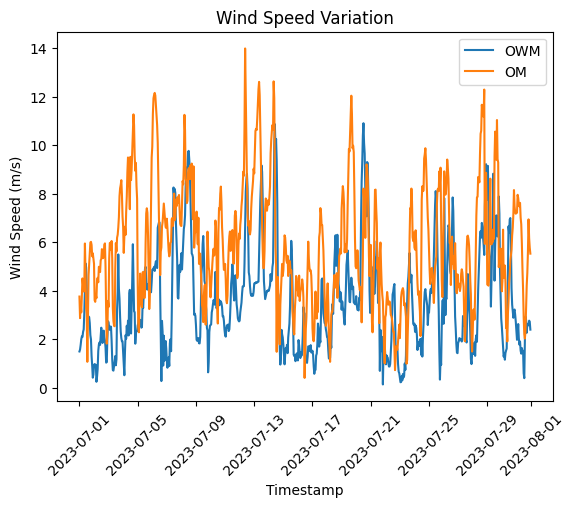

In [6]:
date = '2023-07'

df_OWM = pd.read_csv(f'data\{farm}_hourly_OWM.csv', index_col='timestamp', parse_dates=True)
df_OM = pd.read_csv(f'data\{farm}_hourly_OM.csv', index_col='timestamp', parse_dates=True)

plt.plot(df_OWM.loc[date]['wind_speed'], label='OWM') 
plt.plot(df_OM.loc[date]['wind_speed_10m'], label='OM')   
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Variation')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecasts from API's

## Open Meteo

In [7]:
farm = 'Aurora Wind Power'
save = True
latitude = wind_farms_df.loc[farm]['latitude']
longitude = wind_farms_df.loc[farm]['longitude']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"hourly": ["wind_speed_10m", "wind_speed_80m"],
	"wind_speed_unit": "ms",
	"forecast_days": 1,
	"past_days": 6,
	"models": "icon_seamless"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data
hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_wind_speed_10m = filter(lambda x: x.Variable() == Variable.wind_speed and x.Altitude() == 10, hourly_variables)

hourly_data = {"timestamp": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
# Process all members
for variable in hourly_wind_speed_10m:
	member = variable.EnsembleMember()
	hourly_data[f"wind_speed_10m_member{member}"] = variable.ValuesAsNumpy()

hourly_forecasted = pd.DataFrame(data = hourly_data)
hourly_forecasted['aggregated'] = hourly_forecasted.filter(like = "wind_speed_10m_member").mean(axis = 1)
hourly_forecasted.set_index("timestamp", inplace = True)
print(hourly_dataframe)

Coordinates -32.75°N 18.25°E
Elevation 155.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           wind_speed_100m  temperature_2m  \
timestamp                                                    
2023-03-01 00:00:00+00:00         7.543209           16.40   
2023-03-01 01:00:00+00:00         6.229767           16.15   
2023-03-01 02:00:00+00:00         3.448188           15.55   
2023-03-01 03:00:00+00:00         2.435159           15.50   
2023-03-01 04:00:00+00:00         2.549510           15.25   
...                                    ...             ...   
2024-04-14 19:00:00+00:00         2.662705           12.65   
2024-04-14 20:00:00+00:00         3.023243           12.50   
2024-04-14 21:00:00+00:00         3.361547           12.10   
2024-04-14 22:00:00+00:00         4.123106           11.85   
2024-04-14 23:00:00+00:00         3.969887           11.85   

                           relative_humidity_2m  wind_speed_10m  \
timestamp              

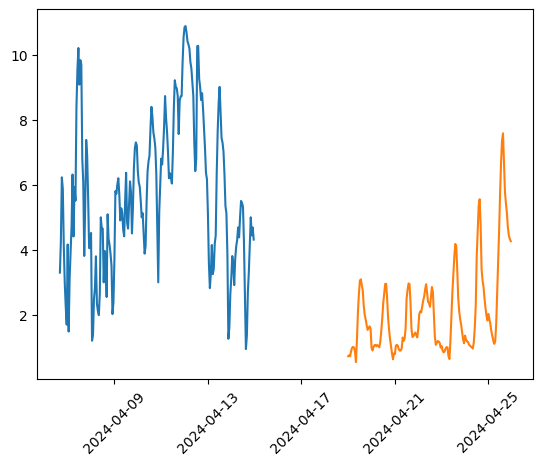

In [8]:
plt.plot(hourly_dataframe[-100 * 2:]["wind_speed_10m"])
plt.plot(hourly_forecasted['aggregated'])
plt.xticks(rotation = 45)
plt.show()